In [20]:
import argparse
from pathlib import Path
import numpy as np
import pandas as pd
import pickle
import string
from functools import partial
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr

from mist import utils

import matplotlib.pyplot as plt
import seaborn as sns
from mist.utils.plot_utils import *

In [21]:
plt.style.use(['seaborn-white', 'seaborn-paper'])
plt.rc('font', family='sans serif')
# sns.set_palette(['#9e0059', '#6da7de', '#ee266d', '#dee000', '#eb861e'])
sns.set_context('paper', font_scale=1.3)

In [22]:
METRIC_POOL_TUPLES = [("Cosine", "spectra"),
                      ("LL", "spectra"),
                      ("LL", "bit")]

In [23]:
def ll(pred, targ):
    """nll.

    Args:
        pred:
        targ:
    """
    log = partial(utils.clamped_log_np, _min=-5)
    ll = targ * log(pred) + (1 - targ) * log(1 - pred)
    return ll


def cos_sim(pred, targ):
    """nll.

    Args:
        pred:
        targ:
    """
    pred

    sim = cosine_similarity(pred, targ)
    sim = np.diag(sim)
    return sim[:, None]


def tani(pred, targ):
    """tani.

    Args:
        pred:
        targ:
    """
    pred = np.copy(pred)
    above_thresh = pred >= 0.5
    pred[above_thresh] = 1.0
    pred[~above_thresh] = 0.0

    pred, targ = pred.astype(bool), targ.astype(bool)
    denom = np.logical_or(pred, targ).sum(-1)
    num = np.logical_and(pred, targ).sum(-1)
    res = num / denom
    return res[:, None]


def get_metric(metric):
    """get_metric.

    Args:
        metric:
    """
    """get_metric.

    Args:
        metric:
    """
    return {
        "LL": ll,
        "Cosine": cos_sim,
        "Tani": tani,
    }[metric]

In [24]:
def compute_fp_results(pred_file, baseline_file, model_name, baseline_name, metric, pool_method):
    # Get preds and sort
    fp_preds = pickle.load(open(pred_file, "rb"))
    a_names, a_preds, a_targs = fp_preds["names"], fp_preds["preds"], fp_preds["targs"]
    a_names, a_preds, a_targs = np.array(a_names), np.asarray(a_preds), np.asarray(a_targs)
    #print(a_preds[0], a_targs[0])
    #a_names = np.array(a_names)
    a_keep_set = set(a_names)

    # Get baselines
    b_preds = pickle.load(open(baseline_file, "rb"))
    b_names, b_preds, b_targs = b_preds["names"], b_preds["preds"], b_preds["targs"]
    b_names, b_preds, b_targs = np.array(b_names), np.array(b_preds), np.array(b_targs)
    b_keep_set = set(b_names)

    # Get set overlap of names
    keep_set = b_keep_set.intersection(a_keep_set)

    # Filter both down to overlap
    b_keep = [i in keep_set for i in b_names]
    b_names, b_preds, b_targs = b_names[b_keep], b_preds[b_keep], b_targs[b_keep]

    a_keep = [i in keep_set for i in a_names]
    a_names, a_preds, a_targs = a_names[a_keep], a_preds[a_keep], a_targs[a_keep]

    a_sort = np.argsort(a_names)
    b_sort = np.argsort(b_names)
    a_names, a_preds, a_targs = a_names[a_sort], a_preds[a_sort], a_targs[a_sort]
    b_names, b_preds, b_targs = b_names[b_sort], b_preds[b_sort], b_targs[b_sort]

    print(a_targs.shape, b_targs.shape)
    
    assert np.all(a_targs == b_targs)

    # Next compute matrix predictions
    # Start with likelihoods
    val_fn = get_metric(metric)
    a_res = val_fn(a_preds, a_targs)
    b_res = val_fn(b_preds, b_targs)

    print(f"{model_name} Mean values: {a_res.mean()}")
    print(f"{baseline_name} Mean values: {b_res.mean()}")

    if pool_method == "spectra":
        a_res = a_res.mean(1)
        b_res = b_res.mean(1)
    elif pool_method == "bit":
        a_res = a_res.mean(0)
        b_res = b_res.mean(0)

    return a_res, b_res

In [25]:
def compute_results_df(pred_files, metric, pool_method, out_dir):
    # Get dataset names
    datasets = list(set([p[2] for p in pred_files]))
    datasets.sort()
    val_fn = get_metric(metric)

    result_df = pd.DataFrame(columns=["score", "model", "dataset"])

    for dataset in datasets:
        print(f"current dataset: {dataset}")

        dataset_preds = [p for p in pred_files if p[2] == dataset]
        keep_sets = []

        all_names, all_preds, all_targs, all_res = [], [], [], []

        for fp_pred_file, _, _ in dataset_preds:

            fp_preds = pickle.load(open(fp_pred_file, "rb"))

            names, preds, targs = fp_preds["names"], fp_preds["preds"], fp_preds["targs"]
            _, unique_idx = np.unique(names, return_index=True)

            all_names.append(names[unique_idx])
            all_preds.append(preds[unique_idx])
            all_targs.append(targs[unique_idx])

            keep_sets.append(list(set(names)))
            print(f"number of names: {len(names)}")


        keep_set = set.intersection(*map(set, keep_sets))

        for i in range(len(all_names)):
            keep = np.asarray([n in keep_set for n in all_names[i]], dtype=bool)
            all_names[i], all_preds[i], all_targs[i] = all_names[i][keep], all_preds[i][keep], all_targs[i][keep]
            sort = np.argsort(all_names[i])
            all_names[i], all_preds[i], all_targs[i] = all_names[i][sort], all_preds[i][sort], all_targs[i][sort]

            res = val_fn(all_preds[i], all_targs[i])
            print(f"Mean values 1: {res.mean()}")
            if pool_method == "spectra":
                res = res.mean(1)
            elif pool_method == "bit":
                res = res.mean(0)
            all_res.append(res)
            print(f"shape results: {res.shape}")
        assert all([np.all(all_targs[i] == all_targs[0]) for i in range(len(all_targs))])

        for i, (_, model_name, dataset) in enumerate(dataset_preds):
            res = pd.DataFrame(all_res[i], columns=["score"])
            res["model"] = model_name
            res["dataset"] = dataset
            result_df = pd.concat([result_df, res], ignore_index=True)


    out_dir.mkdir(exist_ok=True)
    save_file = out_dir / f"result_df_{metric}_{pool_method}.p"
    with open(save_file, "wb") as f:
        pickle.dump(result_df, f)

    return result_df

In [26]:
fp_pred_file = "../results/retrained_models/mist_fp_model_aug/preds_casmi2022/out_preds_single/merged_fp_preds.p"
fp_base_file = "../pretrained_models/mist_canopus_public/fp_model/preds_casmi2022/out_preds_single/merged_fp_preds.p"
fp_model_name = "MIST retrain"
fp_base_name = "MIST public"

save_name = "../../results/reproducibility/fp_scatter/scatter_plots.pdf"

In [31]:
def plot_scatter_and_violin(fp_pred_file, fp_base_file, fp_model_name, fp_base_name, violin_pred_files, save_name):    
    width = 7
    height = width / 1.618

    fig, axes = plt.subplots(2, 3, figsize=(width * 2.2, height * 2.7))
    scatter_axes = axes[0, :]
    violin_axes = axes[1, :]
    fig.tight_layout(h_pad=2)

    # Scatter plots
    for i, (ax, (metric, pool_method)) in enumerate(zip(scatter_axes, METRIC_POOL_TUPLES)):
        a_res, b_res = compute_fp_results(fp_pred_file, fp_base_file, fp_model_name, fp_base_name, metric, pool_method)

        ax.set_box_aspect(1)
        
        # set plot title
        metric_title = {
            "LL": "Log Likelihood",
            "Cosine": "Cosine Similarity",
            "Tani": "Tanimoto Similarity",
        }.get(metric)
        pool_title = {"bit": "(fingerprint bits)", "spectra": "(spectra)"}.get(pool_method)
        top_title = f"{metric_title}\n{pool_title}"
        ax.set_title(top_title)

        sns.kdeplot(
                x=a_res.squeeze(),
                y=b_res.squeeze(),
                fill=True,
                bw_adjust=0.6,
                cmap="Oranges",
                ax=ax,
                cbar=False,
                cut=0,
                levels=8
            )
        
        a_higher = (a_res - b_res) > 0
        b_higher = (b_res - a_res) > 0
        num_a_higher = a_higher.sum()
        num_b_higher = b_higher.sum()
        c1 = ["red", "red"]
        ax.scatter(
            a_res[a_higher],
            b_res[a_higher],
            marker="X",
            s=0.2,
            alpha=0.2,  # 0.2,
            #c=c1[0],
            c="orange"
        )
        ax.scatter(
            a_res[b_higher],
            b_res[b_higher],
            marker="X",
            s=0.2,
            alpha=0.2,  # 0.2,
            #c=c1[1],
            c="orange"
        )

        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        lb = np.min([xlim[0], ylim[0]])
        ub = np.max([xlim[1], ylim[1]])

        ax.plot(
            np.linspace(-100, 100, 100),
            np.linspace(-100, 100, 100),
            c="black",
            linewidth=0.7,
            linestyle="--",
        )

        # Subset to 95th percentile for zoom
        min_el = [min(i, j) for i, j in zip(a_res.squeeze(), b_res.squeeze())]
        max_el = [min(i, j) for i, j in zip(a_res.squeeze(), b_res.squeeze())]

        lb, ub = np.percentile(min_el, 1), np.percentile(max_el, 99)

        if metric == "LL":
            ax.set_xlim([lb, 0])
            ax.set_ylim([lb, 0])
        elif metric == "Cosine":
            ax.set_xlim([0,1])
            ax.set_ylim([0,1])
        elif metric == "Tani":
            ax.set_xlim([0,1])
            ax.set_ylim([0,1])

        ax.set_xlabel(f"{fp_model_name}")

        print(f"{fp_model_name} is higher: {num_a_higher}")
        print(f"{fp_base_name} is higher: {num_b_higher}")
        left, width = 0, 0.5  # .25, 0.25 #0.5
        bottom, height = 0.1, 0.5
        right = left + width
        top = bottom + height

        corr, _ = pearsonr(a_res, b_res)
        ax.text(
            right,
            bottom,
            f"correlation = {corr : 0.2f}".expandtabs(),
            transform=ax.transAxes,
            # fontsize=15,
        )

        ax.text(-0.1, 1.1, string.ascii_lowercase[i], transform=ax.transAxes, size=15, weight='bold')
        
    scatter_axes[0].set_ylabel(f"{fp_base_name}")

    # Violin plots
    out_dir = Path(save_name).parent
    result_dfs = []
    for metric, pool_method in METRIC_POOL_TUPLES:
        res = compute_results_df(violin_pred_files, metric, pool_method, out_dir)
        result_dfs.append(res)

    for i, ((metric, pool_method), res_df, ax) in enumerate(zip(METRIC_POOL_TUPLES, result_dfs, violin_axes)):
        metric_title = {
            "LL": "Log likelihood",
            "Cosine": "Cosine similarity",
            "Tani": "Tanimoto similarity",
        }.get(metric)
        pool_to_title = {"bit": "(fingerprint bits)", "spectra": "(spectra)"}.get(
            pool_method
        )
        ax.set_title(f"{metric_title}\n{pool_to_title}")

        ax.set_box_aspect(1)

        sns.violinplot(
            data=res_df,
            x="dataset",
            y="score",
            hue="model",
            cut=0,
            palette=sns.color_palette("tab10"),
            # linewidth=1,
            legend=False,
            ax=ax,
            order=["MIST", "CASMI 2022"],
        )

        ax.get_legend().remove()
        ax.set(xlabel=None)
        ax.set(ylabel=None)

        ax.text(-0.1, 1.1, string.ascii_lowercase[i+3], transform=ax.transAxes, size=15, weight='bold')

    violin_axes[0].set_ylabel("Score")

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=len(result_dfs))

    plt.savefig(save_name, format="pdf", bbox_inches="tight", dpi=600, transparent=True)

(170, 4096) (170, 4096)
MIST retrain Mean values: 0.4880990239905105
MIST public Mean values: 0.49189803029998586
MIST retrain is higher: 79
MIST public is higher: 91
(170, 4096) (170, 4096)
MIST retrain Mean values: -0.035125669091939926
MIST public Mean values: -0.03573821485042572
MIST retrain is higher: 98
MIST public is higher: 72
(170, 4096) (170, 4096)
MIST retrain Mean values: -0.035125669091939926
MIST public Mean values: -0.03573821485042572
MIST retrain is higher: 1926
MIST public is higher: 2170
current dataset: CASMI 2022
number of names: 170
number of names: 170
number of names: 170
Mean values 1: 0.49189803029998586
shape results: (170,)
Mean values 1: 0.4880990239905105
shape results: (170,)
Mean values 1: 0.5279082822247306
shape results: (170,)
current dataset: MIST
number of names: 819
number of names: 819
number of names: 10709
Mean values 1: 0.6992460916943783
shape results: (819,)
Mean values 1: 0.682938451151743
shape results: (819,)
Mean values 1: 0.861790319945

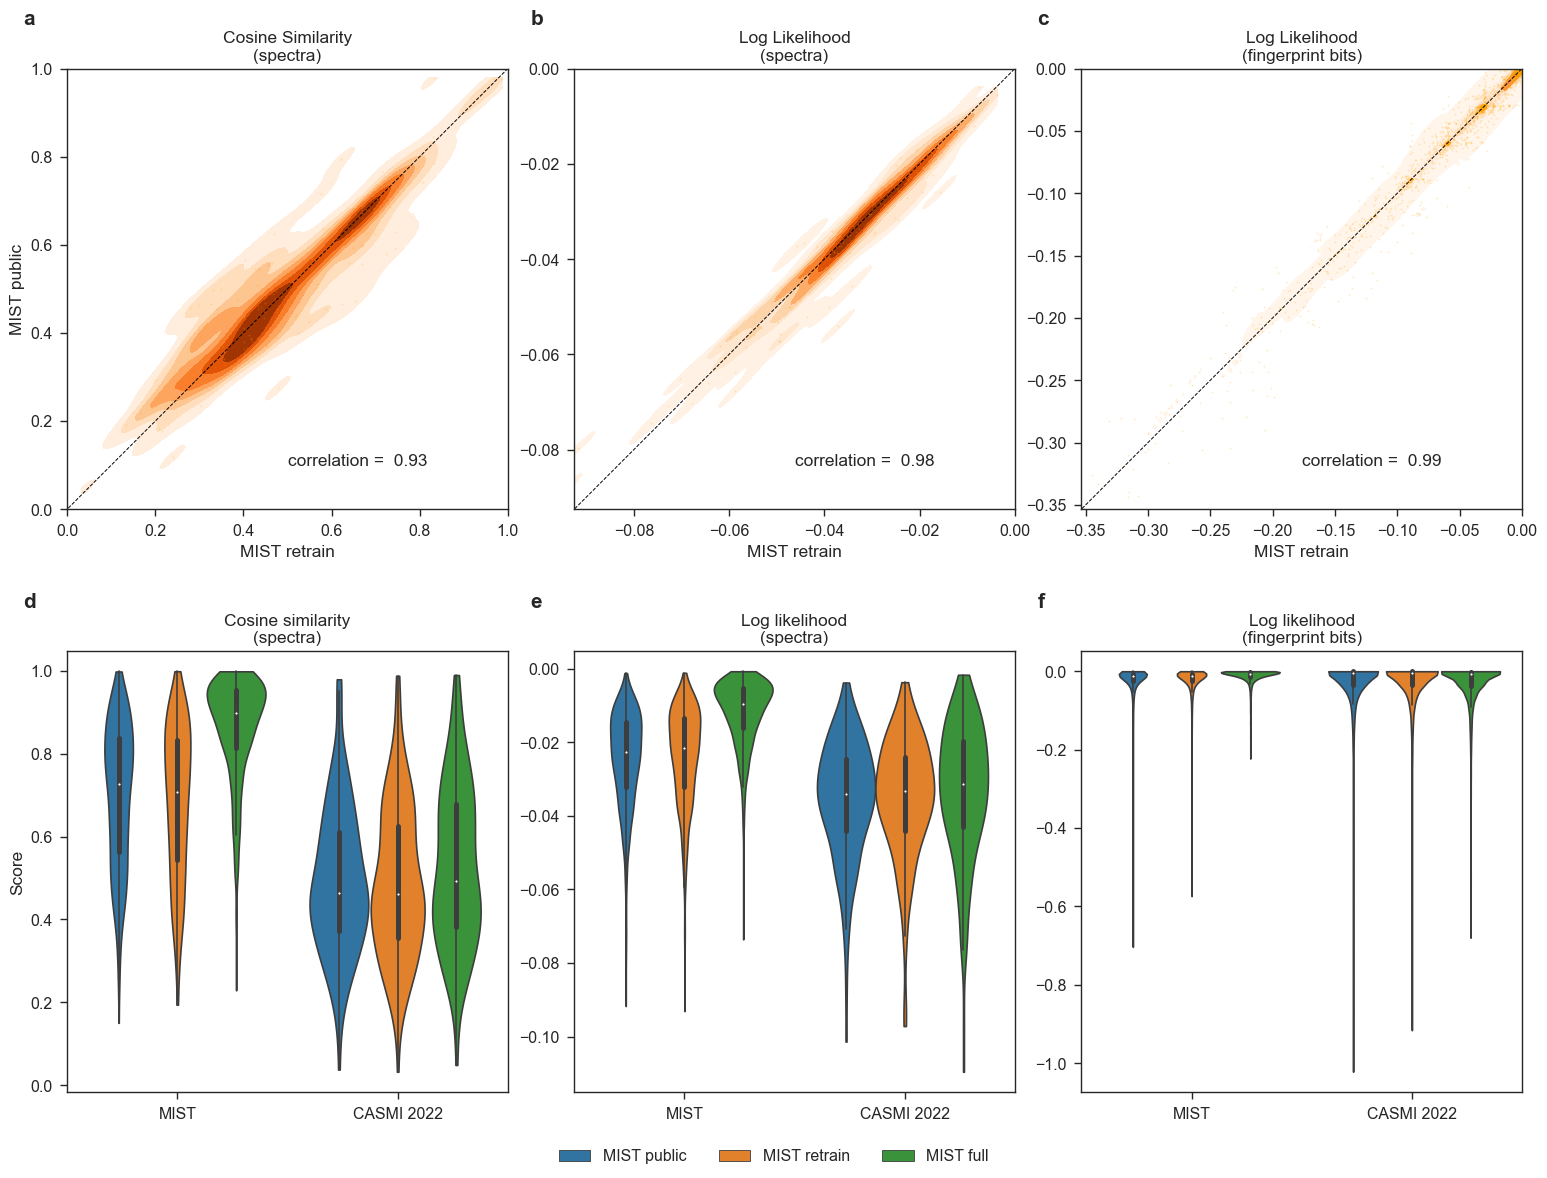

In [32]:
# casmi scatter and violin plots
fp_pred_file = "../../results/retrained_models/mist_fp_model_aug/preds_casmi2022/out_preds_single/merged_fp_preds.p"
fp_base_file = "../../pretrained_models/mist_canopus_public/fp_model/preds_casmi2022/out_preds_single/merged_fp_preds.p"
fp_model_name = "MIST retrain"
fp_base_name = "MIST public"

violin_pred_files = [ # (filename, model, dataset)
    ("../../pretrained_models/mist_canopus_public/fp_model/preds_casmi2022/out_preds_single/merged_fp_preds.p", "MIST public", "CASMI 2022"),
    ("../../results/retrained_models/mist_fp_model_aug/preds_casmi2022/out_preds_single/merged_fp_preds.p", "MIST retrain", "CASMI 2022"),
    ("../../pretrained_models/mist_full/fp_model/preds_casmi2022/out_preds_single/merged_fp_preds.p", "MIST full", "CASMI 2022"),
    ("../../pretrained_models/mist_canopus_public/fp_model/preds_canopus_train_public/out_preds_single/merged_fp_preds.p", "MIST public", "MIST"),
    ("../../results/retrained_models/mist_fp_model_aug/preds_canopus_train_public/out_preds_single/merged_fp_preds.p", "MIST retrain", "MIST"),
    ("../../pretrained_models/mist_full/fp_model/preds_canopus_train_public/out_preds_single/merged_fp_preds.p", "MIST full", "MIST"),
    ]

save_name = "../../results/reusability/scatter_violin.pdf"

plot_scatter_and_violin(fp_pred_file, fp_base_file, fp_model_name, fp_base_name, violin_pred_files, save_name)